In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [2]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [3]:
idx = 99
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0  MAC000231 2011-12-02  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1  MAC000231 2011-12-03  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2  MAC000231 2011-12-04  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3  MAC000231 2011-12-05  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4  MAC000231 2011-12-06  0.039  0.030  0.000  0.036  0.033  0.000  0.028   

    hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  hh_46  \
0  0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520  0.646   
1  0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310  0.105   
2  0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176  0.101   
3  0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766  0.299   
4  0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529  0.112   

   hh_47  
0  0.052  
1  0.068  
2  0.155  
3  0.000  
4  0.006  

[5 rows x 50 columns]

### This function is used to fill the gaps between days (missing days)

In [4]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [5]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [6]:
block

LCLid        day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0      MAC000231 2011-12-02  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1      MAC000231 2011-12-03  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2      MAC000231 2011-12-04  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3      MAC000231 2011-12-05  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4      MAC000231 2011-12-06  0.039  0.030  0.000  0.036  0.033  0.000  0.028   
...          ...        ...    ...    ...    ...    ...    ...    ...    ...   
33220  MAC005019 2014-02-23  0.212  0.170  0.145  0.228  0.123  0.081  0.130   
33221  MAC005019 2014-02-24  0.064  0.107  0.107  0.122  0.095  0.132  0.085   
33222  MAC005019 2014-02-25  0.053  0.067  0.060  0.076  0.051  0.070  0.033   
33223  MAC005019 2014-02-26  0.045  0.049  0.077  0.032  0.051  0.065  0.042   
33224  MAC005019 2014-02-27  0.057  0.040  0.095  0.029  0.033  0.049  0.067   

        hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  \
0      0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520   
1      0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310   
2      0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176   
3      0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766   
4      0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529   
...      ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
33220  0.079  ...  0.092  0.102  0.081  0.111  0.072  0.135  0.116  0.133   
33221  0.137  ...  0.103  0.106  0.103  0.099  0.072  0.097  0.057  0.088   
33222  0.061  ...  0.805  1.235  1.243  1.150  0.547  0.418  0.125  0.076   
33223  0.039  ...  0.480  0.271  0.214  0.149  0.116  0.165  0.058  0.060   
33224  0.047  ...  0.167  0.250  0.449  0.195  0.122  0.154  0.129  0.095   

       hh_46  hh_47  
0      0.646  0.052  
1      0.105  0.068  
2      0.101  0.155  
3      0.299  0.000  
4      0.112  0.006  
...      ...    ...  
33220  0.092  0.067  
33221  0.046  0.077  
33222  0.041  0.090  
33223  0.077  0.045  
33224  0.061  0.054  

[33225 rows x 50 columns]

In [7]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-7-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


day      LCLid   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5   hh_6  \
0     2011-12-02  MAC000231  0.076  0.064  0.005  0.000  0.061  0.009  0.000   
1     2011-12-03  MAC000231  0.000  0.033  0.048  0.000  0.011  0.055  0.007   
2     2011-12-04  MAC000231  0.046  0.023  0.000  0.055  0.209  0.036  0.053   
3     2011-12-05  MAC000231  0.000  0.062  0.002  0.016  0.045  0.000  0.035   
4     2011-12-06  MAC000231  0.039  0.030  0.000  0.036  0.033  0.000  0.028   
...          ...        ...    ...    ...    ...    ...    ...    ...    ...   
33446 2014-02-23  MAC005019  0.212  0.170  0.145  0.228  0.123  0.081  0.130   
33447 2014-02-24  MAC005019  0.064  0.107  0.107  0.122  0.095  0.132  0.085   
33448 2014-02-25  MAC005019  0.053  0.067  0.060  0.076  0.051  0.070  0.033   
33449 2014-02-26  MAC005019  0.045  0.049  0.077  0.032  0.051  0.065  0.042   
33450 2014-02-27  MAC005019  0.057  0.040  0.095  0.029  0.033  0.049  0.067   

        hh_7  ...  hh_38  hh_39  hh_40  hh_41  hh_42  hh_43  hh_44  hh_45  \
0      0.051  ...  0.052  0.103  0.210  0.062  0.065  0.109  0.048  0.520   
1      0.018  ...  0.000  0.422  0.510  0.085  0.146  0.484  0.135  0.310   
2      0.001  ...  0.088  0.293  0.306  0.111  0.278  0.614  0.723  0.176   
3      0.027  ...  0.069  0.719  0.637  0.625  0.652  0.313  0.593  0.766   
4      0.040  ...  0.094  0.082  0.106  0.047  0.058  0.567  0.616  0.529   
...      ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
33446  0.079  ...  0.092  0.102  0.081  0.111  0.072  0.135  0.116  0.133   
33447  0.137  ...  0.103  0.106  0.103  0.099  0.072  0.097  0.057  0.088   
33448  0.061  ...  0.805  1.235  1.243  1.150  0.547  0.418  0.125  0.076   
33449  0.039  ...  0.480  0.271  0.214  0.149  0.116  0.165  0.058  0.060   
33450  0.047  ...  0.167  0.250  0.449  0.195  0.122  0.154  0.129  0.095   

       hh_46  hh_47  
0      0.646  0.052  
1      0.105  0.068  
2      0.101  0.155  
3      0.299  0.000  
4      0.112  0.006  
...      ...    ...  
33446  0.092  0.067  
33447  0.046  0.077  
33448  0.041  0.090  
33449  0.077  0.045  
33450  0.061  0.054  

[33451 rows x 50 columns]

In [8]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-8-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


LCLid           timestamp  energy_consumption frequency  \
0        MAC000231 2011-12-02 00:00:00               0.076     30min   
1        MAC000231 2011-12-02 00:30:00               0.064     30min   
2        MAC000231 2011-12-02 01:00:00               0.005     30min   
3        MAC000231 2011-12-02 01:30:00               0.000     30min   
4        MAC000231 2011-12-02 02:00:00               0.061     30min   
...            ...                 ...                 ...       ...   
1594795  MAC005019 2014-02-20 21:30:00               0.154     30min   
1594796  MAC005019 2014-02-20 22:00:00               0.129     30min   
1594797  MAC005019 2014-02-20 22:30:00               0.095     30min   
1594798  MAC005019 2014-02-20 23:00:00               0.061     30min   
1594799  MAC005019 2014-02-20 23:30:00               0.054     30min   

         serie_length  
0               38880  
1               38880  
2               38880  
3               38880  
4               38880  
...               ...  
1594795         30720  
1594796         30720  
1594797         30720  
1594798         30720  
1594799         30720  

[1594800 rows x 5 columns]

In [9]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col

In [10]:
ts_df = expand_form[expand_form.LCLid=="MAC005019"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [11]:
ts_df

LCLid  energy_consumption frequency  serie_length
timestamp                                                                 
2012-05-22 00:00:00  MAC005019               0.101     30min         30720
2012-05-22 00:30:00  MAC005019               0.110     30min         30720
2012-05-22 01:00:00  MAC005019               0.078     30min         30720
2012-05-22 01:30:00  MAC005019               0.063     30min         30720
2012-05-22 02:00:00  MAC005019               0.109     30min         30720
...                        ...                 ...       ...           ...
2014-02-20 21:30:00  MAC005019               0.154     30min         30720
2014-02-20 22:00:00  MAC005019               0.129     30min         30720
2014-02-20 22:30:00  MAC005019               0.095     30min         30720
2014-02-20 23:00:00  MAC005019               0.061     30min         30720
2014-02-20 23:30:00  MAC005019               0.054     30min         30720

[30720 rows x 4 columns]

In [12]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [13]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [14]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [15]:
ts_df

LCLid  energy_consumption frequency  serie_length  \
timestamp                                                                    
2012-05-22 00:00:00  MAC005019               0.101     30min         30720   
2012-05-22 00:30:00  MAC005019               0.110     30min         30720   
2012-05-22 01:00:00  MAC005019               0.078     30min         30720   
2012-05-22 01:30:00  MAC005019               0.063     30min         30720   
2012-05-22 02:00:00  MAC005019               0.109     30min         30720   
...                        ...                 ...       ...           ...   
2014-02-20 21:30:00  MAC005019               0.154     30min         30720   
2014-02-20 22:00:00  MAC005019               0.129     30min         30720   
2014-02-20 22:30:00  MAC005019               0.095     30min         30720   
2014-02-20 23:00:00  MAC005019               0.061     30min         30720   
2014-02-20 23:30:00  MAC005019               0.054     30min         30720   

                    weekday_name  weekday  week  day  hour        date  month  \
timestamp                                                                       
2012-05-22 00:00:00      Tuesday        1    21   22     0  2012-05-22      5   
2012-05-22 00:30:00      Tuesday        1    21   22     0  2012-05-22      5   
2012-05-22 01:00:00      Tuesday        1    21   22     1  2012-05-22      5   
2012-05-22 01:30:00      Tuesday        1    21   22     1  2012-05-22      5   
2012-05-22 02:00:00      Tuesday        1    21   22     2  2012-05-22      5   
...                          ...      ...   ...  ...   ...         ...    ...   
2014-02-20 21:30:00     Thursday        3     8   20    21  2014-02-20      2   
2014-02-20 22:00:00     Thursday        3     8   20    22  2014-02-20      2   
2014-02-20 22:30:00     Thursday        3     8   20    22  2014-02-20      2   
2014-02-20 23:00:00     Thursday        3     8   20    23  2014-02-20      2   
2014-02-20 23:30:00     Thursday        3     8   20    23  2014-02-20      2   

                    month_name  year  
timestamp                             
2012-05-22 00:00:00        May  2012  
2012-05-22 00:30:00        May  2012  
2012-05-22 01:00:00        May  2012  
2012-05-22 01:30:00        May  2012  
2012-05-22 02:00:00        May  2012  
...                        ...   ...  
2014-02-20 21:30:00   February  2014  
2014-02-20 22:00:00   February  2014  
2014-02-20 22:30:00   February  2014  
2014-02-20 23:00:00   February  2014  
2014-02-20 23:30:00   February  2014  

[30720 rows x 13 columns]

In [16]:
daily_df = ts_df.groupby(["year","month","week","day"])[['energy_consumption']].mean()
daily_df

energy_consumption
year month week day                    
2012 5     21   22             0.144083
                23             0.217271
                24             0.208083
                25             0.137937
                26             0.158750
...                                 ...
2014 2     7    16             0.179562
           8    17             0.091937
                18             0.251104
                19             0.117604
                20             0.086521

[640 rows x 1 columns]

In [17]:
daily_df = daily_df.reset_index()
daily_df['timestamp'] = daily_df.apply(
    lambda row: pd.Timestamp(
        year=int(row['year']),
        month=int(row['month']),
        day=int(row['day'])
    ),
    axis=1
)

daily_df = daily_df.set_index('timestamp').sort_index()
daily_df

year  month  week  day  energy_consumption
timestamp                                             
2012-05-22  2012      5    21   22            0.144083
2012-05-23  2012      5    21   23            0.217271
2012-05-24  2012      5    21   24            0.208083
2012-05-25  2012      5    21   25            0.137937
2012-05-26  2012      5    21   26            0.158750
...          ...    ...   ...  ...                 ...
2014-02-16  2014      2     7   16            0.179562
2014-02-17  2014      2     8   17            0.091937
2014-02-18  2014      2     8   18            0.251104
2014-02-19  2014      2     8   19            0.117604
2014-02-20  2014      2     8   20            0.086521

[640 rows x 5 columns]

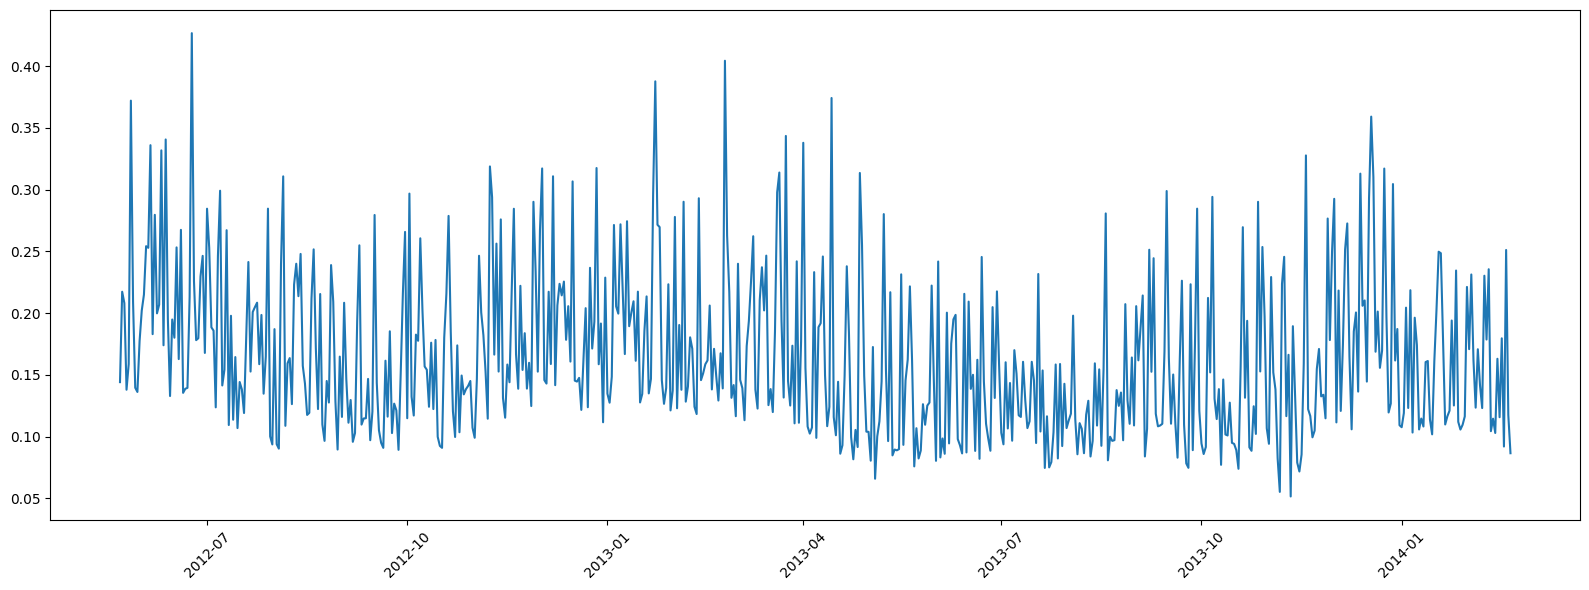

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(daily_df.index, daily_df["energy_consumption"])

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

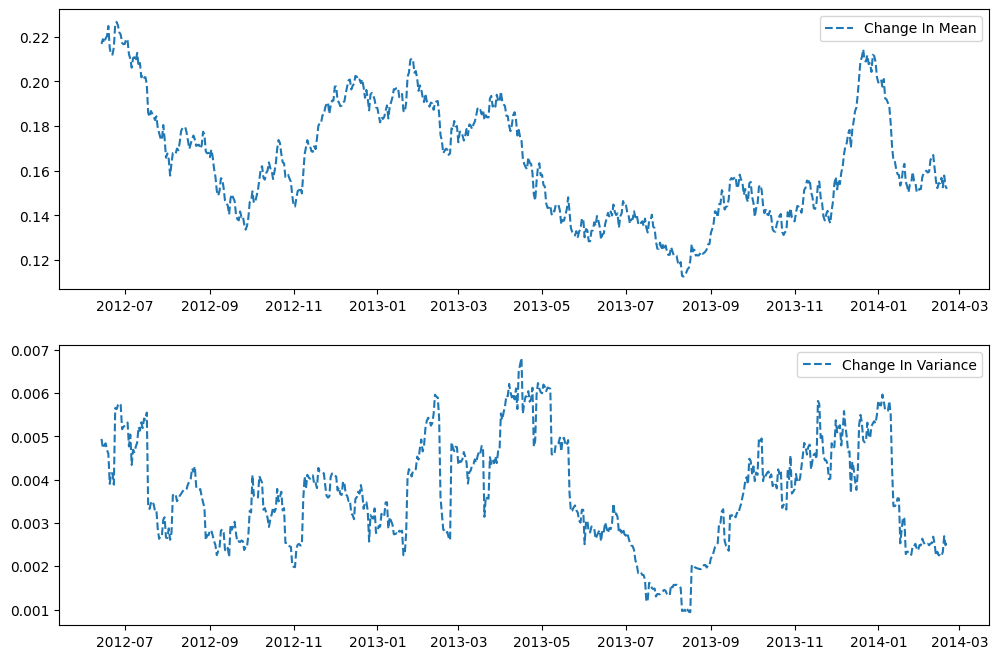

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(daily_df.index, daily_df['energy_consumption'].rolling(window=24).mean() , label='Change In Mean', linestyle='--')
ax[1].plot(daily_df.index, daily_df['energy_consumption'].rolling(window=24).var() , label='Change In Variance', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

### There is change in mean only not in variance so won't make log

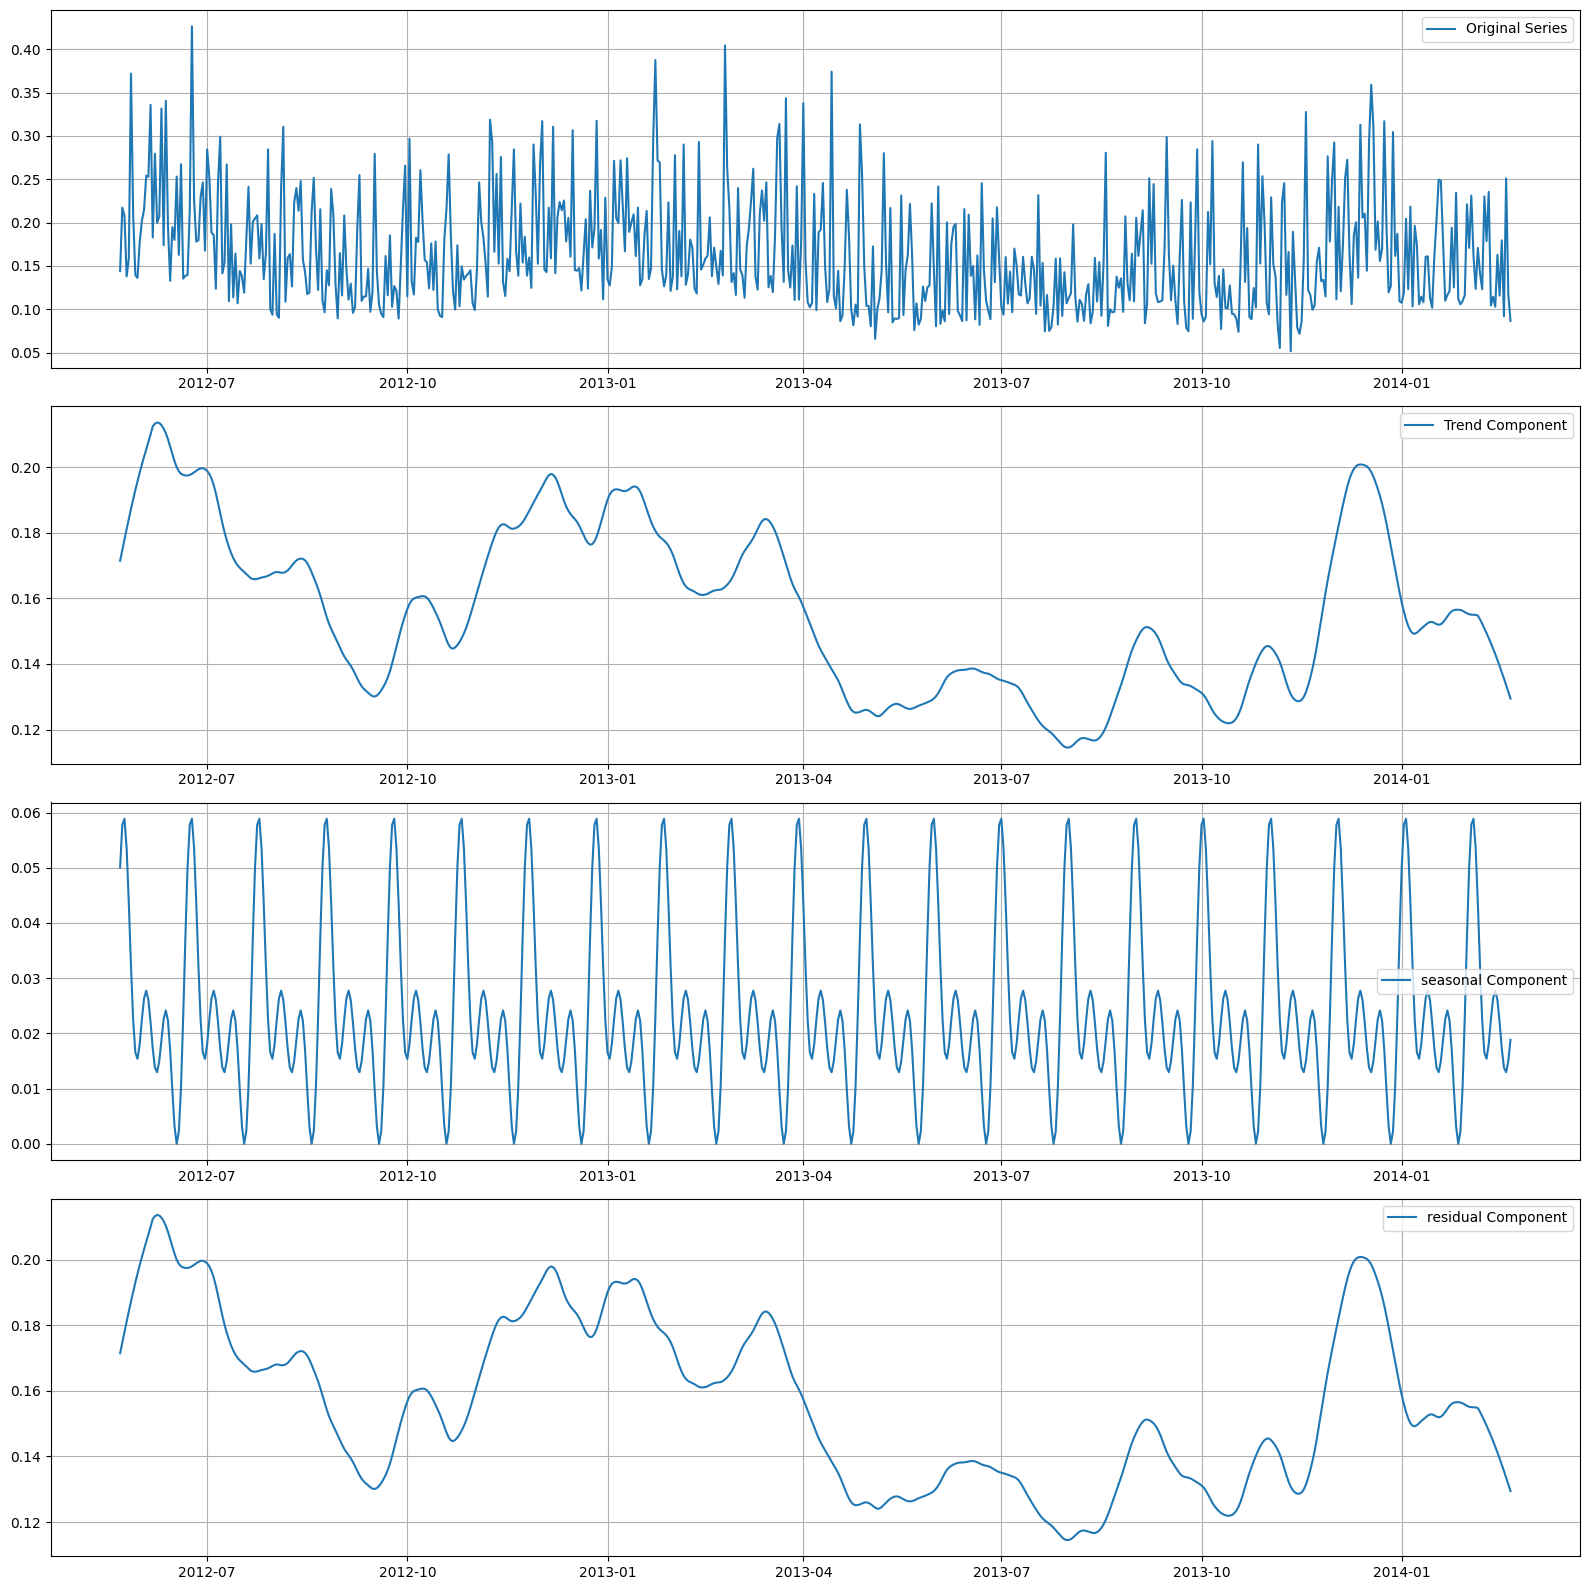

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

trend = lowess(daily_df['energy_consumption'] , range(len(daily_df)), frac=0.05)[:, 1]
detrended_series = daily_df['energy_consumption'] - trend

time = np.arange(len(daily_df['energy_consumption'] ))
seasonal = np.zeros_like(daily_df['energy_consumption'] )
for i in range(1, 3+ 1):
    seasonal += (np.sin(2 * np.pi * i * time / (31)) +
                np.cos(2 * np.pi * i * time / (31)))

seasonal = (seasonal - seasonal.min()) / (seasonal.max() - seasonal.min())
seasonal = seasonal * detrended_series.std()

residual = detrended_series - seasonal
trend = pd.Series(index=daily_df.index, data=trend)
seasonal = pd.Series(index=daily_df.index, data=seasonal)
residual = pd.Series(index=daily_df.index, data=residual)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

axs[0].plot(daily_df.index, daily_df['energy_consumption'], label='Original Series')


axs[1].plot(daily_df.index, trend, label='Trend Component')
axs[2].plot(daily_df.index, seasonal, label='seasonal Component')
axs[3].plot(daily_df.index, trend, label='residual Component')

for ax in axs:
    ax.legend()
    ax.grid()
fig.tight_layout()

In [22]:
daily_df['energy_consumption_decomposed'] = daily_df['energy_consumption'] -trend -seasonal

In [23]:
from statsmodels.tsa.stattools import adfuller, kpss

adfullers_test, adf_pval , _, __, ___, ____= adfuller(daily_df['energy_consumption_decomposed'])
kpss_test, kpss_pval, _, __ = kpss(daily_df['energy_consumption_decomposed'])

if adf_pval < 0.05:
  print("pValue: ", adf_pval)
  print('The series is stationary')
else:
  print('The series is not stationary')

if kpss_pval < 0.05:
  print('The series is not stationary')
else:
  print("pValue: ", kpss_pval)
  print('The series is stationary')

pValue:  1.4714550696289768e-15
The series is stationary
pValue:  0.1
The series is stationary


<ipython-input-23-efed81d466cc>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test, kpss_pval, _, __ = kpss(daily_df['energy_consumption_decomposed'])


### here after decomposition data now is stationary so we can use ml models and get a good predictions

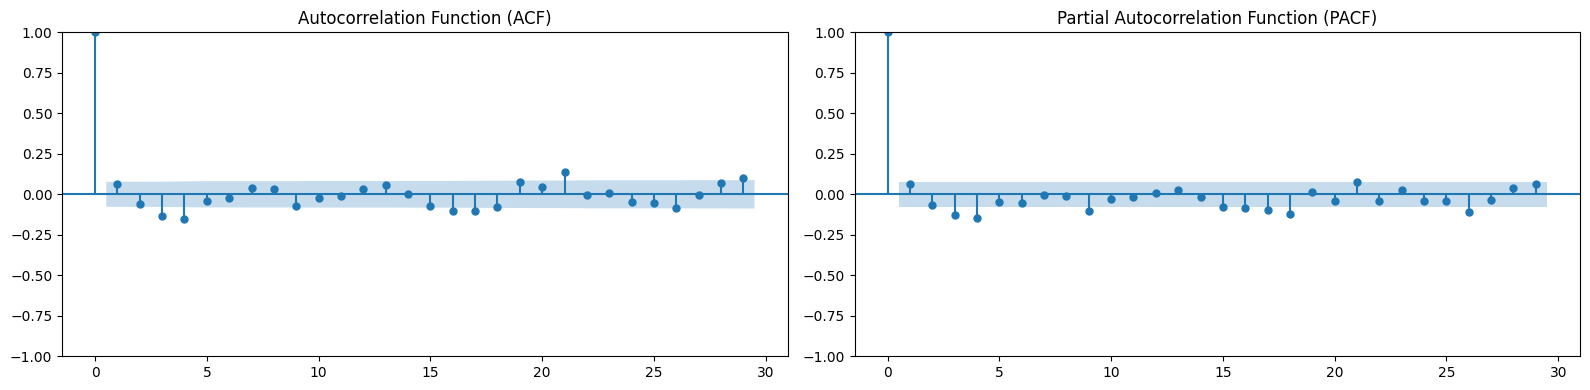

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(daily_df['energy_consumption_decomposed'], ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(daily_df['energy_consumption_decomposed'], ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### After visualize the autocorrelation and PACF i find thet it correlated using 1 lag

### First Approach : Using Delay Embedding with Two Lags

In [25]:
tau = 1
daily_df['Lag_1'] = daily_df['energy_consumption_decomposed'].shift(tau)

daily_df.head()

year  month  week  day  energy_consumption  \
timestamp                                                
2012-05-22  2012      5    21   22            0.144083   
2012-05-23  2012      5    21   23            0.217271   
2012-05-24  2012      5    21   24            0.208083   
2012-05-25  2012      5    21   25            0.137937   
2012-05-26  2012      5    21   26            0.158750   

            energy_consumption_decomposed     Lag_1  
timestamp                                            
2012-05-22                      -0.077486       NaN  
2012-05-23                      -0.015265 -0.077486  
2012-05-24                      -0.028768 -0.015265  
2012-05-25                      -0.096711 -0.028768  
2012-05-26                      -0.069085 -0.096711

### Using Random Forest Algorithm Without Bootstrap

In [27]:
from sklearn.ensemble import RandomForestRegressor
X = daily_df[['Lag_1']]
y = daily_df['energy_consumption_decomposed']

rf_dt_ds_model = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [28]:
daily_df['y_hat_rf'] = rf_dt_ds_model.predict(X) + trend + seasonal

In [29]:
daily_df

year  month  week  day  energy_consumption  \
timestamp                                                
2012-05-22  2012      5    21   22            0.144083   
2012-05-23  2012      5    21   23            0.217271   
2012-05-24  2012      5    21   24            0.208083   
2012-05-25  2012      5    21   25            0.137937   
2012-05-26  2012      5    21   26            0.158750   
...          ...    ...   ...  ...                 ...   
2014-02-16  2014      2     7   16            0.179562   
2014-02-17  2014      2     8   17            0.091937   
2014-02-18  2014      2     8   18            0.251104   
2014-02-19  2014      2     8   19            0.117604   
2014-02-20  2014      2     8   20            0.086521   

            energy_consumption_decomposed     Lag_1  y_hat_rf  
timestamp                                                      
2012-05-22                      -0.077486       NaN  0.135455  
2012-05-23                      -0.015265 -0.077486  0.217271  
2012-05-24                      -0.028768 -0.015265  0.208083  
2012-05-25                      -0.096711 -0.028768  0.137937  
2012-05-26                      -0.069085 -0.096711  0.158750  
...                                   ...       ...       ...  
2014-02-16                       0.024811 -0.045713  0.179562  
2014-02-17                      -0.057401  0.024811  0.091937  
2014-02-18                       0.104590 -0.057401  0.251104  
2014-02-19                      -0.028903  0.104590  0.117604  
2014-02-20                      -0.061749 -0.028903  0.086521  

[640 rows x 8 columns]

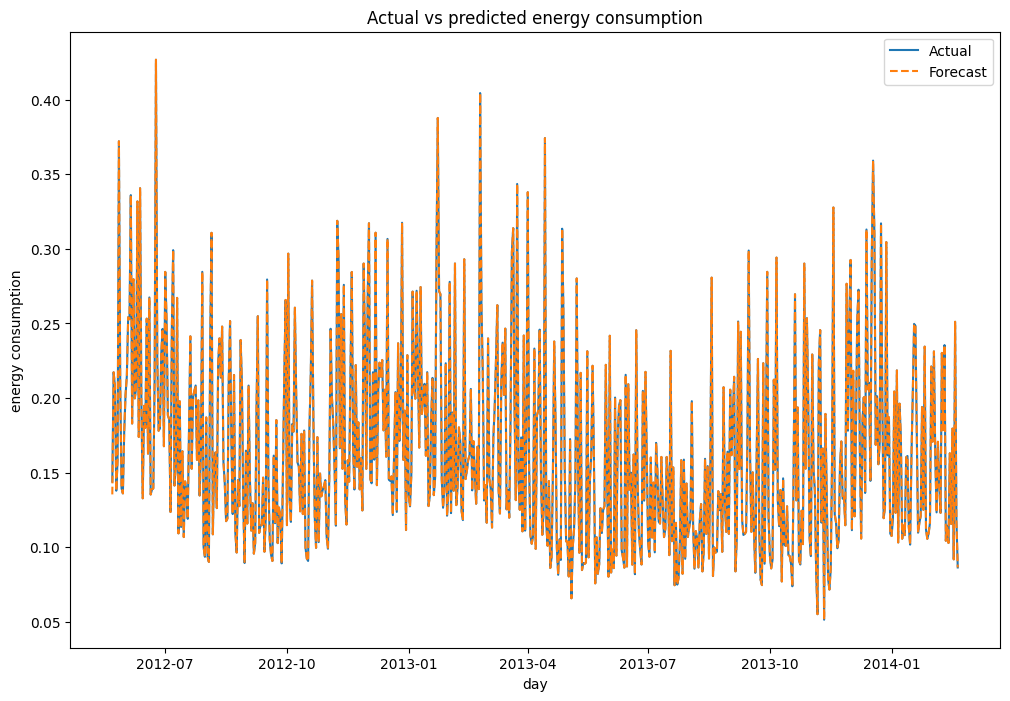

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(daily_df.index, daily_df['energy_consumption'], label='Actual')
ax.plot(daily_df.index, daily_df['y_hat_rf'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('day')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### The fit (predictions) is so good because we make a good analysis :
1- decomposition using Fourier Decomposition making the data stationary

3- find the effected Lags using PACF

4- making the Delay Embedding  

3- using thr Random Forest Algo without bootstrap

4- finally add the seasonality and decomposition again  

In [37]:
h = 31
def forecast_future_ds(model, data, trend,seasonal, steps=31, freq='h'):
    # Starting with the last known lag values
    last_lag1 = data['Lag_1'].iloc[-1]

    # To store future predictions
    future_predictions = []

    # Fill NaN values in the trend and seasonal components, if any, at the end
    trend =trend.dropna()
    seasonal = seasonal.dropna()

    # Assuming the seasonal cycle is 12 months, we can repeat the last known cycle
    seasonal_cycle = seasonal[-31:].tolist()

    # We can take the last known trend change to extrapolate the trend
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([[last_lag1]], columns=['Lag_1'])

        # Predict the next value
        next_value_pred = model.predict(input_df)[0]

        # Update lag values
        last_lag1 = next_value_pred

        # Add back the trend and seasonal components
        # Extrapolate the trend
        next_trend = last_known_trend + trend_diff * (step + 1)

        # Use the corresponding seasonal component
        next_seasonal = seasonal_cycle[step % 31]

        next_value_pred += next_trend + next_seasonal

        future_predictions.append(next_value_pred)

    # Create a date range for the future predictions
    last_date = data.index[-1]


    # Generate future dates
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(1, freq),
        periods=steps,
        freq=freq
    )
    #future_dates = pd.date_range(start=last_date + pd.DateOffset(1, freq), periods=h, freq=freq)
    future_df = pd.DataFrame(index=future_dates, data=future_predictions, columns=["RF_bootstrapFalse_forecast"])


    return future_df

In [38]:
future_df = forecast_future_ds(rf_dt_ds_model, daily_df,  trend , seasonal , h, freq='d')

In [39]:
future_df

RF_bootstrapFalse_forecast
2014-02-21                    0.088175
2014-02-22                    0.234267
2014-02-23                    0.129235
2014-02-24                    0.209929
2014-02-25                    0.071606
2014-02-26                    0.052605
2014-02-27                    0.051168
2014-02-28                    0.058461
2014-03-01                    0.129702
2014-03-02                    0.275345
2014-03-03                    0.154943
2014-03-04                    0.111154
2014-03-05                    0.153806
2014-03-06                    0.110048
2014-03-07                    0.074760
2014-03-08                    0.143361
2014-03-09                    0.201322
2014-03-10                    0.080425
2014-03-11                    0.047935
2014-03-12                    0.044403
2014-03-13                    0.191642
2014-03-14                    0.051886
2014-03-15                    0.126158
2014-03-16                    0.222273
2014-03-17                    0.042590
2014-03-18                    0.002785
2014-03-19                   -0.012973
2014-03-20                   -0.006545
2014-03-21                    0.122370
2014-03-22                    0.074729
2014-03-23                    0.229642

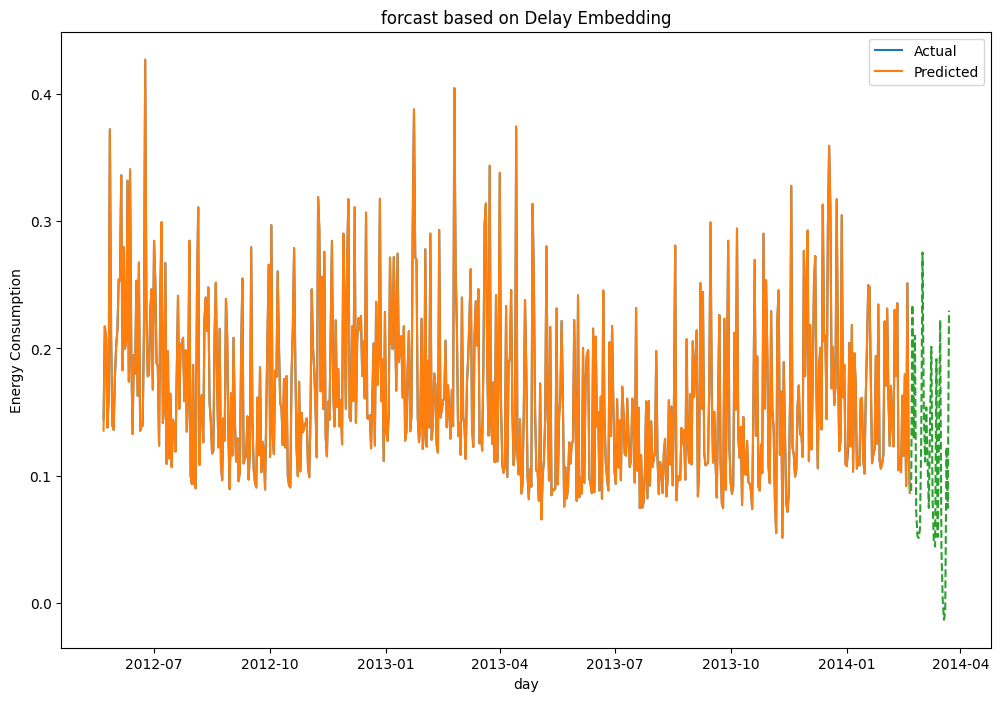

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(daily_df.index, daily_df['energy_consumption'], label='Actual')
ax.plot(daily_df.index, daily_df['y_hat_rf'], label='Predicted')
ax.plot(future_df.index, future_df['RF_bootstrapFalse_forecast'],linestyle='--')

ax.set_title(f'forcast based on Delay Embedding')
ax.set_xlabel('day')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Second Approach : Using Temporal Embedding

In [54]:
import numpy as np

def add_cyclic_features(df):
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)

    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    return df

daily_df_full_embedding = add_cyclic_features(daily_df)

In [55]:
daily_df_full_embedding

year  month  week  day  energy_consumption  \
timestamp                                                
2012-05-22  2012      5    21   22            0.144083   
2012-05-23  2012      5    21   23            0.217271   
2012-05-24  2012      5    21   24            0.208083   
2012-05-25  2012      5    21   25            0.137937   
2012-05-26  2012      5    21   26            0.158750   
...          ...    ...   ...  ...                 ...   
2014-02-16  2014      2     7   16            0.179562   
2014-02-17  2014      2     8   17            0.091937   
2014-02-18  2014      2     8   18            0.251104   
2014-02-19  2014      2     8   19            0.117604   
2014-02-20  2014      2     8   20            0.086521   

            energy_consumption_decomposed     Lag_1  y_hat_rf   day_sin  \
timestamp                                                                 
2012-05-22                      -0.077486       NaN  0.135455 -0.968077   
2012-05-23                      -0.015265 -0.077486  0.217271 -0.998717   
2012-05-24                      -0.028768 -0.015265  0.208083 -0.988468   
2012-05-25                      -0.096711 -0.028768  0.137937 -0.937752   
2012-05-26                      -0.069085 -0.096711  0.158750 -0.848644   
...                                   ...       ...       ...       ...   
2014-02-16                       0.024811 -0.045713  0.179562 -0.101168   
2014-02-17                      -0.057401  0.024811  0.091937 -0.299363   
2014-02-18                       0.104590 -0.057401  0.251104 -0.485302   
2014-02-19                      -0.028903  0.104590  0.117604 -0.651372   
2014-02-20                      -0.061749 -0.028903  0.086521 -0.790776   

            week_sin  month_sin  y_hat_rf_temporal  
timestamp                                           
2012-05-22  0.568065   0.500000           0.144083  
2012-05-23  0.568065   0.500000           0.217271  
2012-05-24  0.568065   0.500000           0.208083  
2012-05-25  0.568065   0.500000           0.137937  
2012-05-26  0.568065   0.500000           0.158750  
...              ...        ...                ...  
2014-02-16  0.748511   0.866025           0.179562  
2014-02-17  0.822984   0.866025           0.091937  
2014-02-18  0.822984   0.866025           0.251104  
2014-02-19  0.822984   0.866025           0.117604  
2014-02-20  0.822984   0.866025           0.086521  

[640 rows x 12 columns]

In [56]:
from sklearn.ensemble import RandomForestRegressor
X = daily_df_full_embedding[['day_sin', 'week_sin' , 'month_sin' , 'year']]
y = daily_df_full_embedding['energy_consumption_decomposed']

rf_dt_ds_model_Temporal = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [57]:
daily_df_full_embedding['y_hat_rf_temporal'] = rf_dt_ds_model_Temporal.predict(X) + trend + seasonal

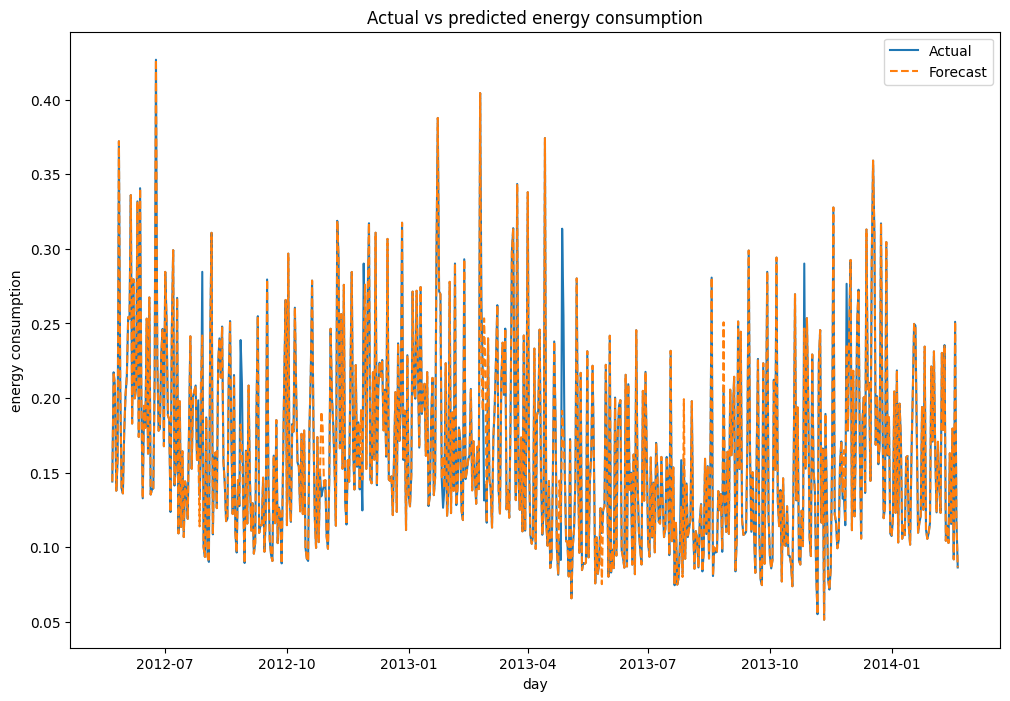

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('day')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### Forcasting using Temporal embedding

In [77]:
def forecast_future_temporal(model, last_known_data, trend, seasonal, steps=31):
    """
    Forecast future daily values with the correct temporal features.

    Parameters:
    - model: Trained forecasting model (expects ['day_sin', 'week_sin', 'month_sin', 'year'])
    - last_known_data: Last row of data with temporal features
    - trend: Trend component from decomposition
    - seasonal: Seasonal component from decomposition
    - steps: Number of days to forecast

    Returns:
    - DataFrame with forecasts and proper DateTimeIndex
    """
    forecasts = []
    timestamps = []

    # Extract initial time components
    day = int(last_known_data['day'])
    month = int(last_known_data['month'])
    year = int(last_known_data['year'])
    week = int(last_known_data['week'])

    # Get last timestamp from historical data
    last_timestamp = daily_df_full_embedding.index[-1]

    # Clean components
    trend = trend.dropna()
    seasonal = seasonal.dropna()

    # Prepare seasonal cycle (monthly seasonality)
    seasonal_cycle = seasonal[-31:].tolist()

    # Compute trend difference and get last trend value
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Calculate cyclical features (same as during training)
        day_sin = np.sin(2 * np.pi * day / 31)
        week_sin = np.sin(2 * np.pi * week / 52)
        month_sin = np.sin(2 * np.pi * month / 12)

        # Build features DataFrame with EXACTLY the features the model expects
        features_df = pd.DataFrame({
            'day_sin': [day_sin],
            'week_sin': [week_sin],
            'month_sin': [month_sin],
            'year': [year]
        })

        # Predict base value
        base_pred = model.predict(features_df)[0]

        # Add components
        current_trend = last_known_trend + trend_diff * (step + 1)
        current_seasonal = seasonal_cycle[step % 31]
        full_prediction = base_pred + current_trend + current_seasonal

        forecasts.append(full_prediction)

        # Generate timestamp
        pred_time = last_timestamp + pd.Timedelta(days=step + 1)
        timestamps.append(pred_time)

        # Update calendar (handles month/year transitions)
        day += 1
        if day > pd.Timestamp(year=year, month=month, day=1).days_in_month:
            day = 1
            month += 1
            if month > 12:
                month = 1
                year += 1
        # Update week (simple implementation - could be improved)
        week += 1
        if week > 52:
            week = 1

    # Create result DataFrame
    forecast_df = pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=["daily_forecast"]
    )

    return forecast_df

# Get last known data point with all required features
last_known_data = daily_df_full_embedding.iloc[-1][['year', 'month', 'week', 'day', 'day_sin', 'week_sin', 'month_sin']].copy()

# Generate forecasts
future_predictions = forecast_future_temporal(rf_dt_ds_model_Temporal,last_known_data,trend,seasonal,steps=31)

In [78]:
future_predictions

daily_forecast
2014-02-21        0.088175
2014-02-22        0.083125
2014-02-23        0.083245
2014-02-24        0.103420
2014-02-25        0.149715
2014-02-26        0.086380
2014-02-27        0.230160
2014-02-28        0.165127
2014-03-01        0.035437
2014-03-02        0.035936
2014-03-03        0.123565
2014-03-04        0.100096
2014-03-05        0.075135
2014-03-06        0.131553
2014-03-07        0.107414
2014-03-08        0.084167
2014-03-09        0.134144
2014-03-10        0.054614
2014-03-11        0.054795
2014-03-12        0.038165
2014-03-13        0.095736
2014-03-14        0.098101
2014-03-15        0.013193
2014-03-16        0.005951
2014-03-17        0.094562
2014-03-18        0.133965
2014-03-19        0.089773
2014-03-20        0.020927
2014-03-21        0.200750
2014-03-22        0.071122
2014-03-23        0.139176

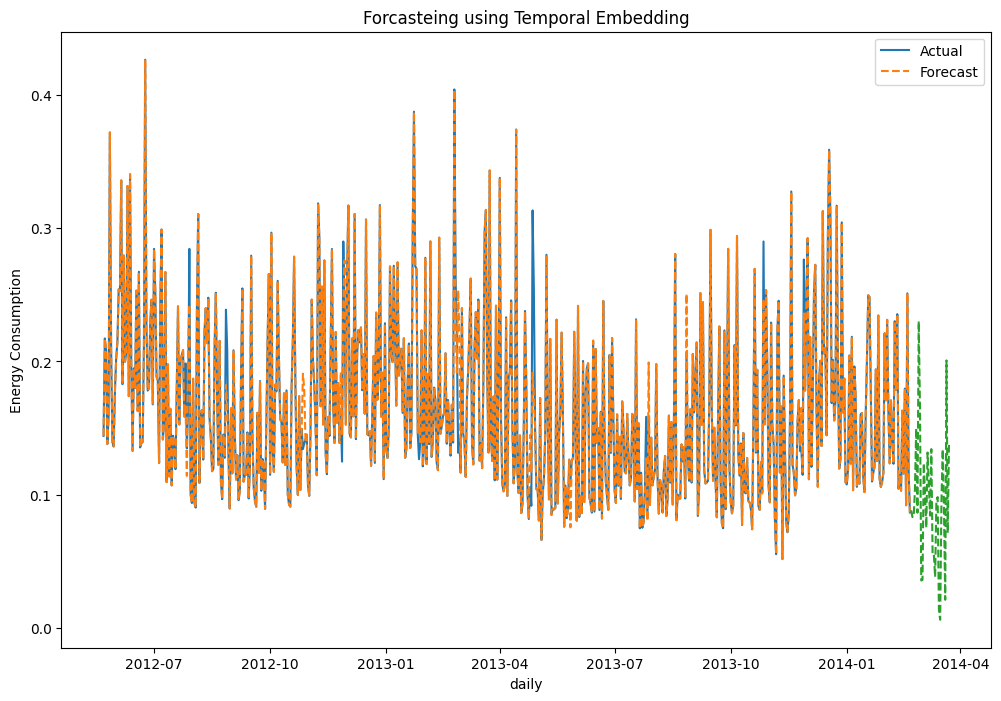

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
future_predictions
ax.plot(future_predictions.index, future_predictions['daily_forecast'],linestyle='--')

ax.set_title(f'Forcasteing using Temporal Embedding')
ax.set_xlabel('daily')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Third Approach : Using Combination between Delay Embedding with Two Lags and Temporal Embedding

In [65]:
from sklearn.ensemble import RandomForestRegressor
X = daily_df_full_embedding[['Lag_1','year', 'day_sin', 'week_sin' , 'month_sin']]
y = daily_df_full_embedding['energy_consumption_decomposed']

rf_dt_ds_model_Temporal_Delay = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal_Delay.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [66]:
daily_df_full_embedding['y_hat_rf_temporal_delay'] = rf_dt_ds_model_Temporal_Delay.predict(X) + trend + seasonal

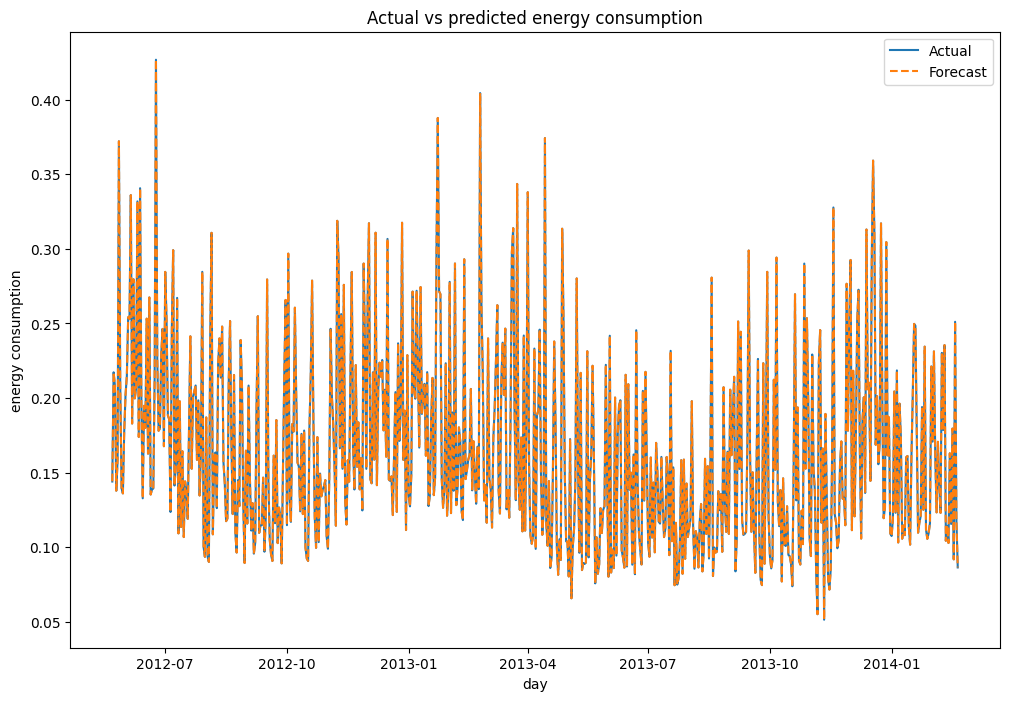

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('day')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

In [71]:
def combined_forecast(model, data, last_known_data, trend, seasonal, steps=31, freq='D'):
    """
    Combined forecast using both lag features and temporal features

    Parameters:
    - model: Trained forecasting model (expects both lag and temporal features)
    - data: Historical data with Lag_1 column
    - last_known_data: Last row with temporal features
    - trend: Trend component
    - seasonal: Seasonal component
    - steps: Number of days to forecast
    - freq: Frequency ('D' for daily)

    Returns:
    - DataFrame with forecasts and proper DateTimeIndex
    """
    forecasts = []
    timestamps = []

    # Initialize lag value
    last_lag1 = data['Lag_1'].iloc[-1]

    # Initialize time components
    day = int(last_known_data['day'])
    month = int(last_known_data['month'])
    year = int(last_known_data['year'])
    week = int(last_known_data['week'])

    # Clean components
    trend = trend.dropna()
    seasonal = seasonal.dropna()
    seasonal_cycle = seasonal[-31:].tolist()
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    # Get last timestamp
    last_timestamp = data.index[-1]

    for step in range(steps):
        # 1. Prepare all features
        # Temporal features (cyclical)
        day_sin = np.sin(2 * np.pi * day / 31)
        week_sin = np.sin(2 * np.pi * week / 52)
        month_sin = np.sin(2 * np.pi * month / 12)

        # Create feature dictionary
        features = {
            'Lag_1': last_lag1,
            'year': year,
            'day_sin': day_sin,
            'week_sin': week_sin,
            'month_sin': month_sin
        }

        # 2. Make prediction
        input_df = pd.DataFrame([features])
        base_pred = model.predict(input_df)[0]

        # 3. Add components
        current_trend = last_known_trend + trend_diff * (step + 1)
        current_seasonal = seasonal_cycle[step % 31]
        full_pred = base_pred + current_trend + current_seasonal

        forecasts.append(full_pred)

        # 4. Update state for next step
        # Update lag
        last_lag1 = base_pred  # Using the prediction before adding components

        # Update time
        day += 1
        if day > pd.Timestamp(year=year, month=month, day=1).days_in_month:
            day = 1
            month += 1
            if month > 12:
                month = 1
                year += 1
        week += 1
        if week > 52:
            week = 1

        # Generate timestamp
        timestamps.append(last_timestamp + pd.Timedelta(days=step+1))

    # Create result DataFrame
    forecast_df = pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=['combined_forecast']
    )

    return forecast_df


# =============================================
# Usage Example
# =============================================
# Get last known data
last_known_data = daily_df_full_embedding.iloc[-1][['year', 'month', 'week', 'day', 'day_sin', 'week_sin', 'month_sin']].copy()

future_predictions = combined_forecast(rf_dt_ds_model_Temporal_Delay,daily_df_full_embedding,last_known_data, trend, seasonal ,steps=31)

In [72]:
future_predictions

combined_forecast
2014-02-21           0.088175
2014-02-22           0.217160
2014-02-23           0.128772
2014-02-24           0.311257
2014-02-25           0.144532
2014-02-26           0.079114
2014-02-27           0.163465
2014-02-28           0.070355
2014-03-01           0.105445
2014-03-02           0.052311
2014-03-03           0.052023
2014-03-04           0.154237
2014-03-05           0.070859
2014-03-06           0.131553
2014-03-07           0.107414
2014-03-08           0.088173
2014-03-09           0.183333
2014-03-10           0.128142
2014-03-11           0.036700
2014-03-12           0.074672
2014-03-13           0.098166
2014-03-14           0.105405
2014-03-15           0.152400
2014-03-16           0.138785
2014-03-17           0.065251
2014-03-18           0.243442
2014-03-19           0.186377
2014-03-20           0.077799
2014-03-21           0.062580
2014-03-22           0.079967
2014-03-23           0.027015

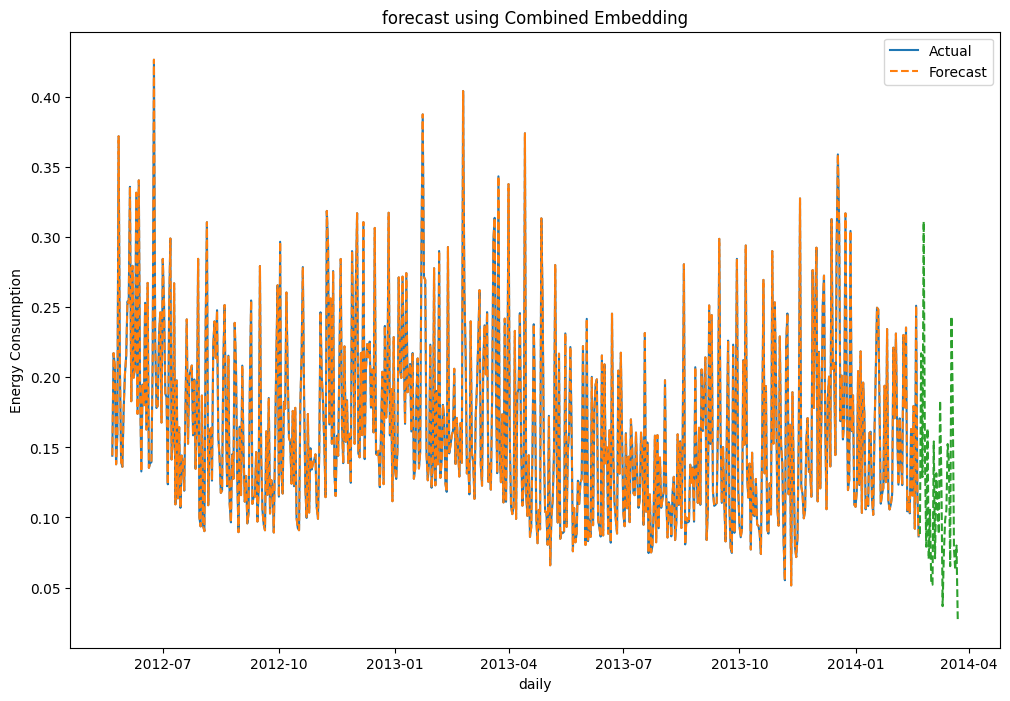

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(daily_df_full_embedding.index, daily_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')
future_predictions
ax.plot(future_predictions.index, future_predictions['combined_forecast'],linestyle='--')

ax.set_title(f'forecast using Combined Embedding')
ax.set_xlabel('daily')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

Combined :

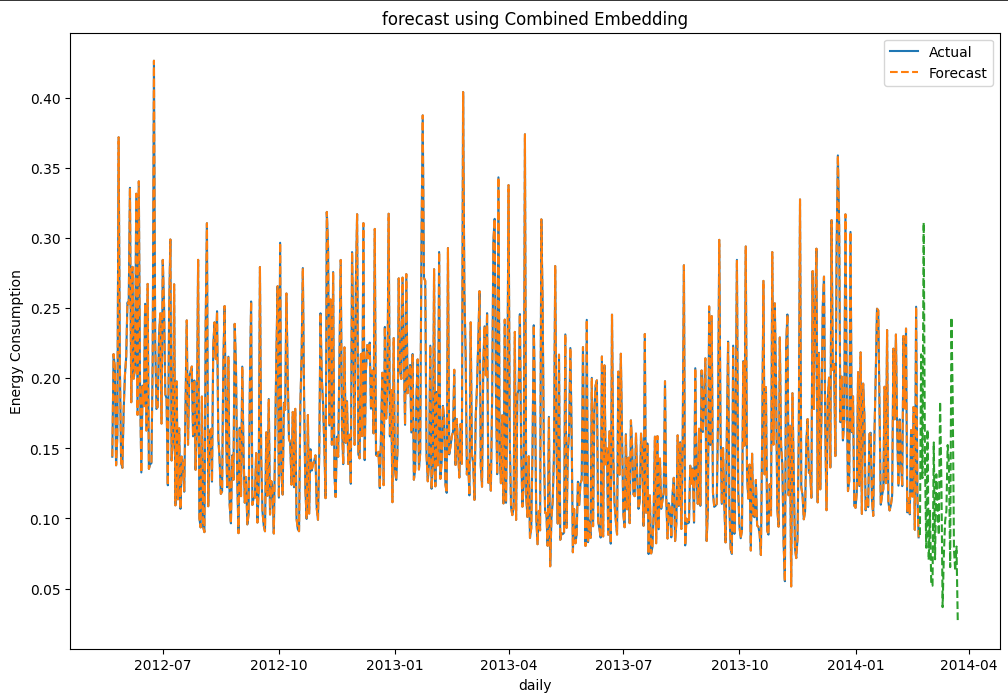

temoral :

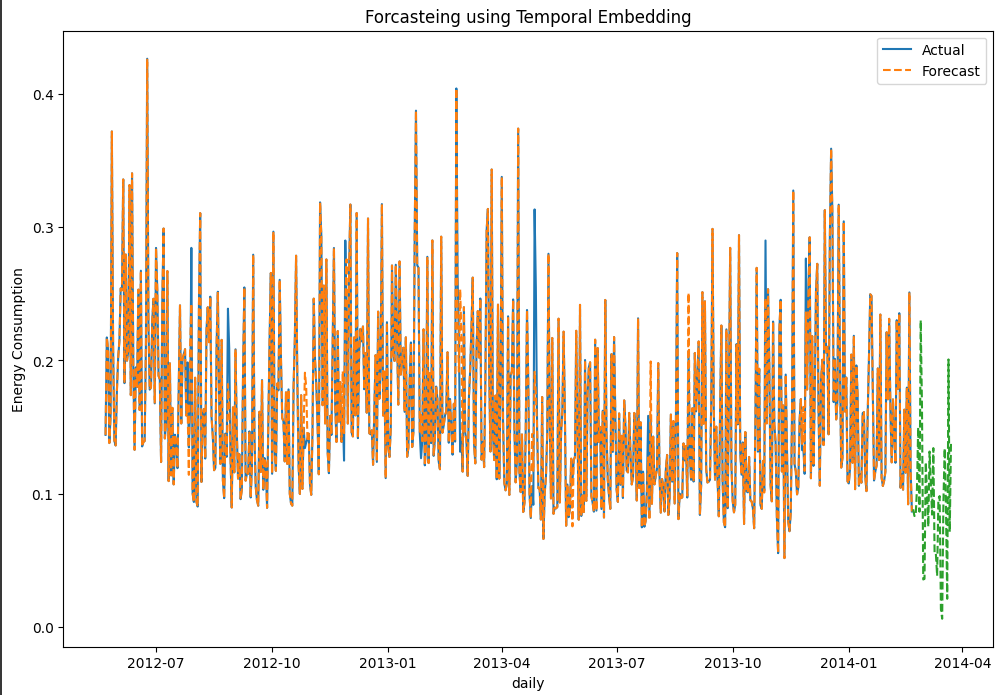

delay:

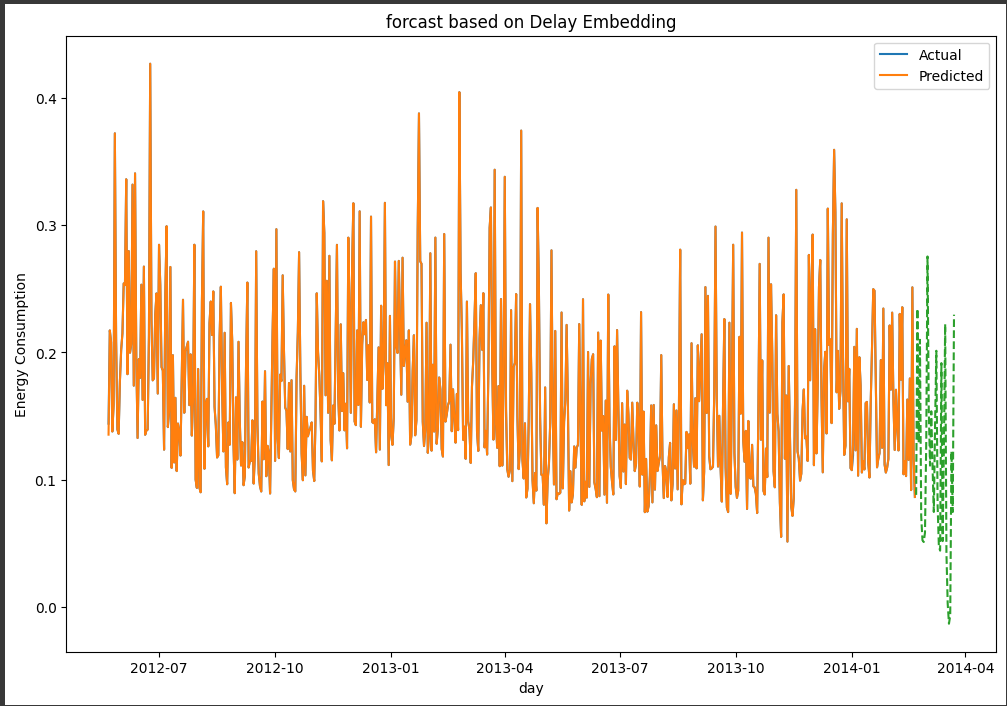

### It seems that the most significant technique without any errors in Delayed Embedding but The combined can be more general without overfit